### This notebook shows how to solve a pulse-echo tomographic problem using the forward operator built in the notebook 'Example_ForwardOperator.ipynb'

We solve the inverse problem related to the linear forward problem

\begin{equation}
\mathbf{d} = \mathbf{F} \mathbf{m}
\end{equation}

by formulating the regularized least-squares minimization problem

\begin{equation}
\min_{\mathbf{m}} f(\mathbf{m}) := \frac{1}{2}||\mathbf{d} - \mathbf{F}\mathbf{m}||^2 + \frac{\lambda}{2}||\mathbf{D}\mathbf{m}||^2,
\end{equation}

where $\mathbf{D}$ is the regularization operator and $\lambda$ is the regularization parameter. Here, we use Tikhonov regularization (order: 0, 1, or 2), and we optimize $\lambda$ using the L-curve approach. This inverse problem has the close-form solution

\begin{equation}
\hat{\mathbf{ m}} = \left(\mathbf{F}^\mathsf{T}\mathbf{F} + \lambda \mathbf{D}^\mathsf{T} \mathbf{D} \right)^{-1} \mathbf{F}^\mathsf{T} \mathbf{ d}.
\end{equation}

In this notebook, the reconstructed model parameters $\hat{\mathbf{m}}$ are the values of the slowness deviation $\Delta s(\mathbf{r}) = 1/c(\mathbf{r}) - 1/c_0$ at each grid point, with $c_0$ being the assumed tissue speed of sound for beamforming.

Author: Naiara Korta Martiartu\
email: naiara.korta@unibe.ch\
Date: March 2024

In [1]:
## import useful packages

%load_ext autoreload
%autoreload 2

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm_notebook

from ray_tracers import ray_tracer_bilint, ray_tracer_pixel, ray_tracer_div_pixel, ray_tracer_div_bilint
from inversion import *

import matplotlib

matplotlib.rcParams.update({'font.size': 10})

Cupy python package not found. Disable GPU options.


#### Define probe properties

In [2]:
# Define probe properties

nelem = 128           # number of transducer elements
pitch = 0.2e-3        # inter-element spacing [m]

# x-position of transducer elements:

xelems = (np.arange(0, nelem) - 0.5 * (nelem - 1)) * pitch 

## 1.- Create synthetic observations

#### Define the grid for observations

In [3]:
grid_def = 0  # 0: grid points at the center of pixels; 1: grid points at vertices of pixels

# Define grid dimensions

x_min_obs, x_max_obs = xelems[0], xelems[-1]                  # minimum and maximum x-position [m]
z_min_obs, z_max_obs = 0, 3.5e-2                              # and maximumminimum z-position [m]
dx_obs = 0.25e-3                                              # grid spacing in x-direction [m]
dz_obs = dx_obs                                               # grid spacing in z-direction [m]
nx_obs = math.ceil((x_max_obs - x_min_obs)/dx_obs) + 1        # number of grid points in x
nz_obs = math.ceil((z_max_obs - z_min_obs)/dz_obs) + 1        # number of grid points in z


# Define grid points along x and z 

x_obs = np.arange(0, nx_obs) * dx_obs - 0.5 * (nx_obs - 1) * dx_obs
z_obs = np.arange(0, nz_obs) * dz_obs + 0.5 * dz_obs if grid_def is 0 else np.arange(0, nz_obs) * dz_obs

# Create meshgrid

xx_obs, zz_obs = np.meshgrid(x_obs, z_obs)

xx_obs = xx_obs.reshape(-1)
zz_obs = zz_obs.reshape(-1)

#### Define medium properties

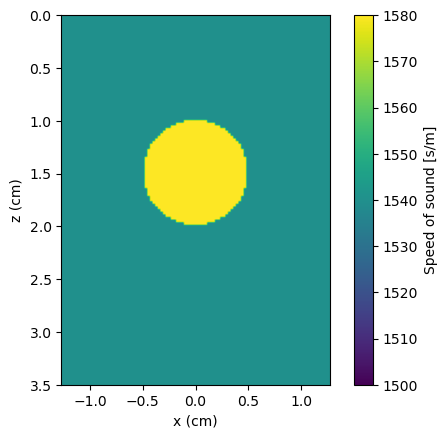

In [4]:
c_0 = 1600 * np.ones_like(xx_obs)   # assumed speed of sound [m/s]

c = 1540 * np.ones_like(xx_obs)     # true speed of sound [m/s]

# add a circular inclusion to the medium:
x_incl = 0                      # x-position center of inclusion [m]
z_incl = 1.5e-2                 # z-position center of inclusion [m]
r_incl = 5e-3                   # radius inclusion [m]
c_incl = 1580                   # velocity of inclusion [m]

inclusion = (xx_obs - x_incl)**2 + (zz_obs - z_incl)**2 <= r_incl**2

c[inclusion] = c_incl           # make inclusion

# slowness deviation:
Delta_s = 1/c - 1/c_0

extent_obs = 100*x_min_obs, 100*x_max_obs, 100*z_max_obs, 100*z_min_obs

plt.imshow(c.reshape((nz_obs, nx_obs)), extent=extent_obs, vmin=1500, vmax=1580)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar().set_label('Speed of sound [s/m]')

#### Define ray tracer

In [5]:
if grid_def:
    tracer = ray_tracer_div_bilint
else:
    tracer = ray_tracer_div_pixel

#### Compute forward operator and observables [i.e., propagation times]

In [6]:
# initialize observables

dobs = np.zeros((nx_obs * nz_obs, nelem))

ind = int(nelem / 2)  # take half of the elements (typically number of elements even)

for iel, xel in enumerate(tqdm_notebook(xelems[:ind])):  # loop over these angles

    # compute non-zero elements of sparse matrices with ray paths
    vals, ind_row, ind_col, ind_row_neg, ind_col_neg = tracer(xel, xx_obs, zz_obs, x_obs[[0, -1]], 
                                                              dx_obs, dz_obs, nx_obs, nz_obs, neg=True)

    # build sparce matrix for xel
    forward_op = csr_matrix((vals, (ind_row, ind_col)), shape=(nx_obs * nz_obs, nx_obs * nz_obs))  
    
    dobs[:, iel] = forward_op.dot(Delta_s)
    
    # build sparce matrix for -xel
    forward_op = csr_matrix((vals, (ind_row_neg, ind_col_neg)), shape=(nx_obs * nz_obs, nx_obs * nz_obs))     
    
    dobs[: , -iel - 1] = forward_op.dot(Delta_s)

  0%|          | 0/64 [00:00<?, ?it/s]

#### Plot progation times per emission

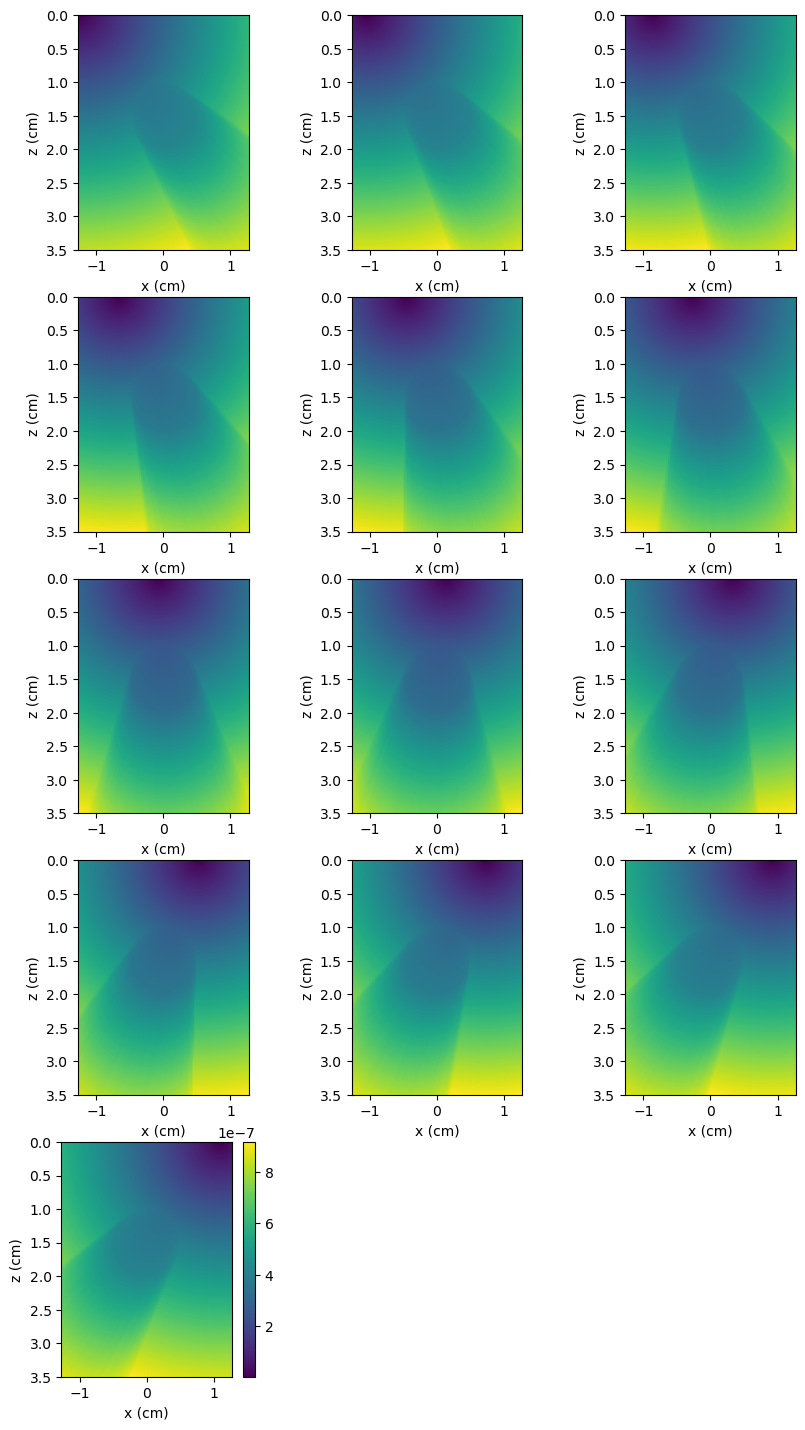

In [7]:
# Plot

fig = plt.figure(figsize=(10,25))

k = 1
for i in range(0,nelem,10):
    
    ax = fig.add_subplot(7, 3, k)
    k += 1
    
    im = ax.imshow(dobs[:, i].reshape((nz_obs, nx_obs)), extent=extent_obs)
    plt.xlabel('x (cm)')
    plt.ylabel('z (cm)')
    
plt.colorbar(im)

## 2.- Create inversion grid and build forward operator

#### Define tomographic grid (inverse crime if this grid is equal to the observations grid)

In [8]:
grid_def = 0  # 0: grid points at the center of pixels; 1: grid points at vertices of pixels

# Define grid dimensions

x_min, x_max = xelems[0], xelems[-1]          # minimum and maximum x-position [m]
z_min, z_max = 0, 3.5e-2                      # and maximumminimum z-position [m]
# !!! NOTE: use coarser grid spacing than before to avoid inverse crime !!!
dx = 0.5e-3                                   # grid spacing in x-direction [m] 
dz = dx                                       # grid spacing in z-direction [m]
nx = math.ceil((x_max - x_min)/dx) + 1        # number of grid points in x
nz = math.ceil((z_max - z_min)/dz) + 1        # number of grid points in z


# Define grid points along x and z

x = np.arange(0, nx) * dx - 0.5 * (nx - 1) * dx
z = np.arange(0, nz) * dz + 0.5 * dz if grid_def is 0 else np.arange(0, nz) * dz

# Create meshgrid

xx, zz = np.meshgrid(x, z)

xx = xx.reshape(-1)
zz = zz.reshape(-1)

#### Compute forward operator

In [9]:
# initialize forward operator

forward_op = [0] * nelem

ind = int(nelem / 2)  # take half of the elements (typically number of elements is even)

for iel, xel in enumerate(tqdm_notebook(xelems[:ind])):  # loop over these elements

    # compute non-zero elements of sparse matrices with ray paths
    vals, ind_row, ind_col, ind_row_neg, ind_col_neg = tracer(xel, xx, zz, x[[0, -1]], dx, dz, nx, nz, neg=True)

    # build sparse matrix for xel
    forward_op[iel] = csr_matrix((vals, (ind_row, ind_col)), shape=(nx * nz, nx * nz))  
    
    # build sparse matrix for -xel
    forward_op[-iel - 1] = csr_matrix((vals, (ind_row_neg, ind_col_neg)), shape=(nx * nz, nx * nz)) 

  0%|          | 0/64 [00:00<?, ?it/s]

#### Interpolate observations to the tomographic grid and add Gaussian noise

In [26]:
# standard deviation of the Gaussian noise

sigma = np.mean(dobs[:, 0])/20

# initialize observables

dobs_interp = np.zeros((nx * nz, nelem))


for iel in tqdm_notebook(range(nelem)):  # loop over all elements and interpolate

    # Define interpolator for bivariate spline approximation over rectilinear grid
    interpolator = RectBivariateSpline(z_obs, x_obs, dobs[:,iel].reshape((nz_obs, nx_obs)))

    # noise
    noise = sigma * np.random.randn(nx * nz)
    
    # interpolate to tomographic gridpoints
    dobs_interp[:,iel] = interpolator(z, x).reshape(-1) + noise

  0%|          | 0/128 [00:00<?, ?it/s]

#### Plot progation times per emission

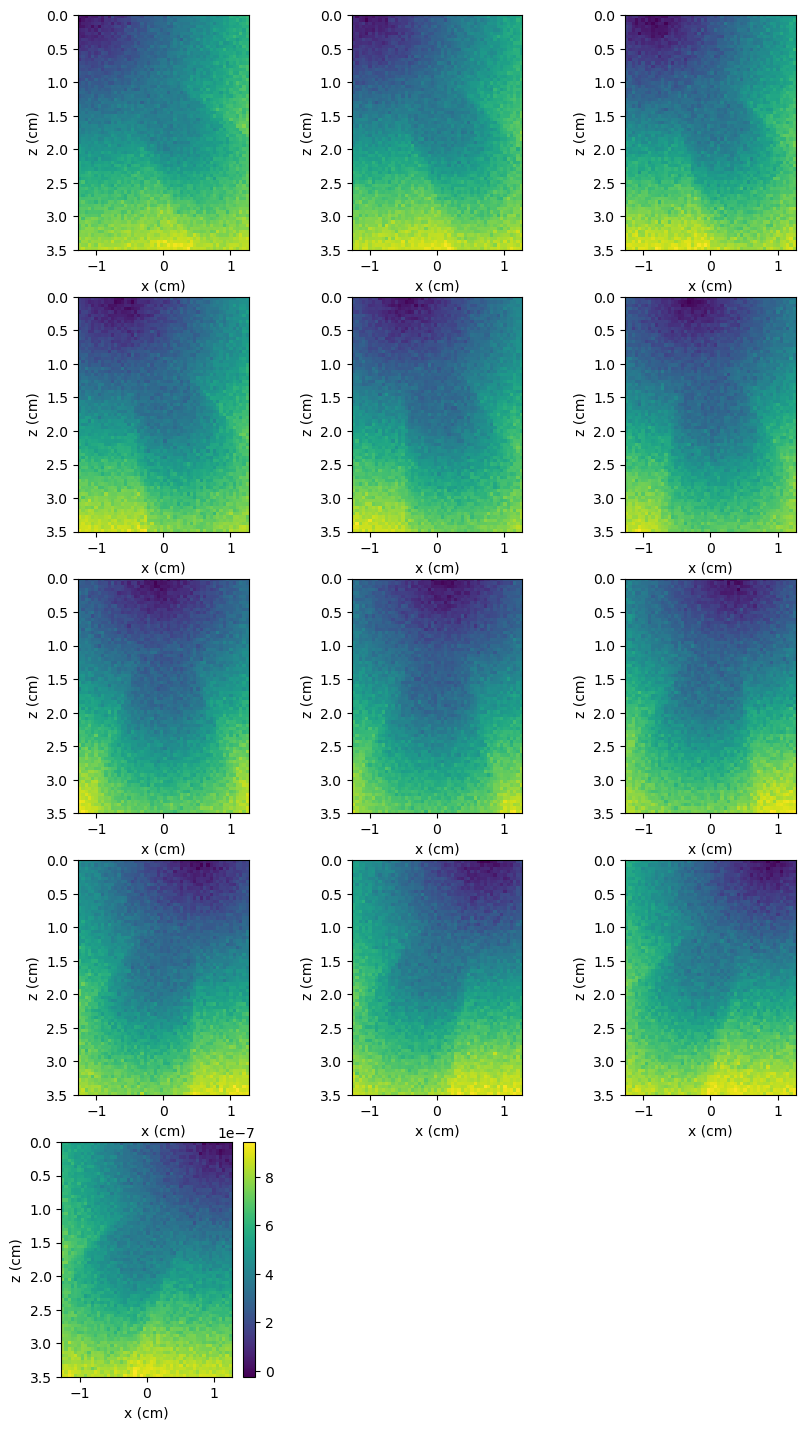

In [27]:
# Plot

fig = plt.figure(figsize=(10,25))

extent = 100*x_min, 100*x_max, 100*z_max, 100*z_min

k = 1
for i in range(0,nelem,10):
    
    ax = fig.add_subplot(7, 3, k)
    k += 1
    
    im = ax.imshow(dobs_interp[:, i].reshape((nz, nx)), extent=extent)
    plt.xlabel('x (cm)')
    plt.ylabel('z (cm)')
    
plt.colorbar(im)

## 3.- Inversion

#### Run the inversion

In [45]:
reg_x = 1e-3     # regularization parameter in x-direction
reg_z = reg_x    # regularization parameter in z-direction


# reconstruct slowness deviation (delta_s) and speed of sound (sos)
delta_s, sos = inversion(dobs_interp, forward_op, nx, nz, c_0[0], reg_parameter=[reg_x, reg_z], order=2)

--------------------------------------------------
Start inversion...
...done!
Run time: 5.72 sec
--------------------------------------------------
Misfit reduction:         94.75 %


#### Plot reconstructed speed of sound

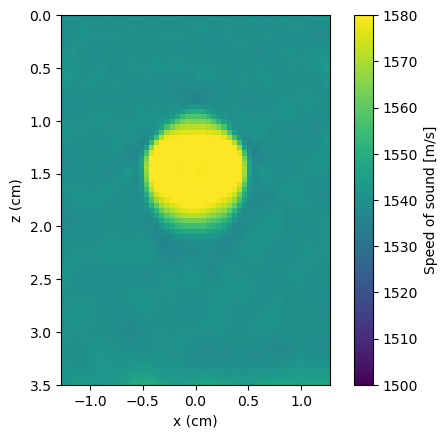

In [46]:
plt.imshow(sos.reshape((nz, nx)), extent=extent, vmin=1500, vmax=1580)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar().set_label('Speed of sound [m/s]')

#### Plot axial and lateral profiles

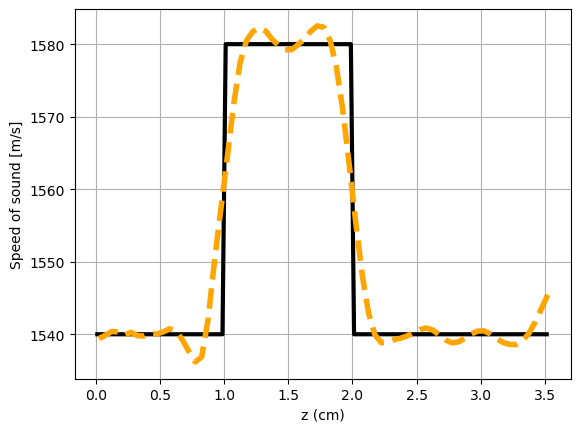

In [47]:
# axial profile

plt.plot(100*z_obs, c.reshape((nz_obs, nx_obs))[:, round(nx_obs/2)], 'k', linewidth=3)
plt.plot(100*z, sos.reshape((nz, nx))[:, round(nx/2)], '--',linewidth=4, color='orange')
plt.xlabel('z (cm)')
plt.ylabel('Speed of sound [m/s]')
plt.grid()


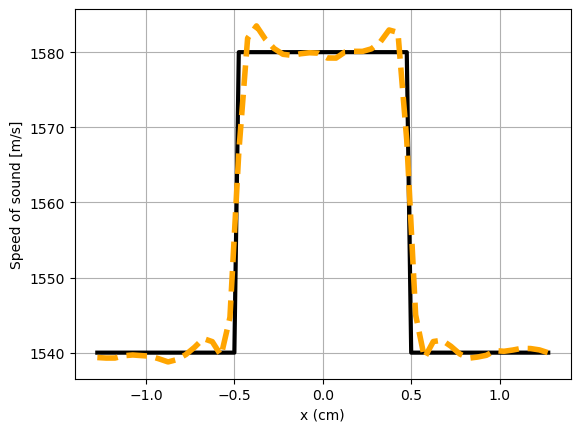

In [48]:
# lateral profile

plt.plot(100*x_obs, c.reshape((nz_obs, nx_obs))[round(z_incl/dz_obs), :], 'k', linewidth=3)
plt.plot(100*x, sos.reshape((nz, nx))[round(z_incl/dz), :], '--',linewidth=4, color='orange')
plt.xlabel('x (cm)')
plt.ylabel('Speed of sound [m/s]')
plt.grid()

#### L-curve approach to optimize the regularization parameter

--------------------------------------------------
Starting 10 inversions to compute L-curve...
--------------------------------------------------
Start inversion...
...done!
Run time: 5.60 sec
--------------------------------------------------
Misfit reduction:         94.30 %
--------------------------------------------------
Start inversion...
...done!
Run time: 5.70 sec
--------------------------------------------------
Misfit reduction:         94.68 %
--------------------------------------------------
Start inversion...
...done!
Run time: 5.92 sec
--------------------------------------------------
Misfit reduction:         94.75 %
--------------------------------------------------
Start inversion...
...done!
Run time: 6.08 sec
--------------------------------------------------
Misfit reduction:         94.77 %
--------------------------------------------------
Start inversion...
...done!
Run time: 7.21 sec
--------------------------------------------------
Misfit reduction:      

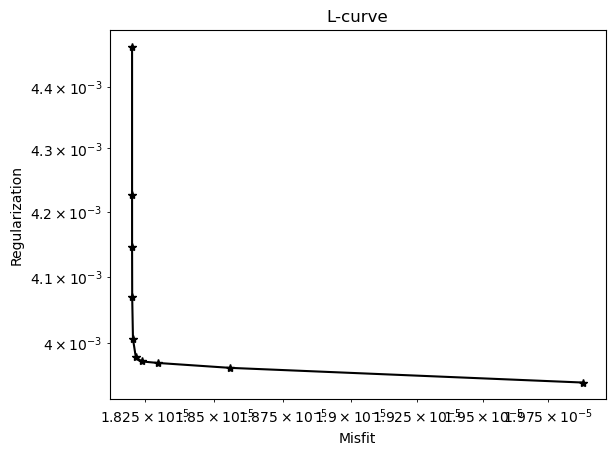

In [32]:
reg_params = np.logspace(-1, -10, 10)

plot_lcurve(dobs_interp, forward_op, nx, nz, c_0[0], order=1, reg_params=reg_params,
                reg_anis_ratio=1.0, savefig=False)